# 1. Abstract

This ML mid term project compares 4 classical Machine learning algorithms utilizing the Fetal Health Classification task
1. K means implementation using vanilla python
2. `sklearn` implementation of KNN pipeline
3. A balanced `Decision Tree` classifier
4. `linear regression` baseline that treats ordinal labels as continuous values

As per the requirements from this mid term assignment, K means satisfy the minimum of 1 implementation of a machine learning algorithm from scratch using maximally only low level NumPy vectorization

KNN, linear regression and decision tree fullfills the requirement for 1 algorithm using an external ML library

##### Summary of results

- K means discovers coarse groupings but lacks granularity
- KNN provided the best accuracy when features are standardized
- The decision tree provides intretable rules and competitive recall on the `Pathological` class
- Linear regression is rudimentary, it underfits on non linear class boundaries. Linear regression however provided transparent ordinal baseline metrics
---

## 2. Introduction

Classical Machine learning models and algorithm has existed for decades at this point, and they are not unfamaliar to the area of medical diagnostic and have proven to provide accurate and reliable results when applied correctly

#### 2.1 Obsterics & Carditocogram

In the field of Obsterics, Cardiotocogram, also known as CTG is the main method of measuring and monitoring fetal health for diagnostic purpose

However there exist a problem here, different doctors intepret the same findings differently, a phenomenon known as inter observer variability

Classical Machine learning algorithms here bridges the gap by providing reproducible and consistent risk assessment

---

## 2.3 Dataset & rationale

##### For this study, I decided to use the **Fetal Health Classification** dataset from the public data repository - Kaggle.

-  I chose this dataset as fetal health classification is a high-impact & meaningful medical problem such as classifying fetal mortality risk,
 - Understanding fetal health through ML may provides insights to the medical community, which can be useful for reducing infant mortality, this is extremely beneficial to society
 - This dataset is a fully vectorizable, which satisfies  the projects unique technical constraints.


**Dataset Overview:**

* **Source:**: 
- Cardiotocogram (CTG) exams classified by expert obstetricians (according to kaggle descripton).

* **dataset Dimensions:** 
- 2126 samples with 21 numerical features 
- (e.g., *baseline heart rate*, *fetal movements*, *uterine contractions*).


**Target Variabls:** 
- Multiple labels of fetal health:
    1.  Normal
    2.  Suspect
    3.  Pathological

---
- Note, this implementation requires an internet connection to load the datasets from ```kagglehub```
---

#### Ensure required libraries are downloaded and loaded with `$pip`

*Libraries*

1. `kagglehub`
2. `numpy`
3. `pandas`
4. `scikit-learn` / `sklearn`
5. `matplotlib`
6. `jupytter notebook`

In [47]:
%%capture
#Ensure pip is up to date
%pip install -q --upgrade pip
#Install kagglehub
%pip install -q kagglehub
%pip install -q "kagglehub[pandas-datasets]"
#Install other dependencies
%pip install -q matplotlib numpy pandas scikit-learn
%pip install -q pandas
%pip install -q matplotlib
%pip install -q notebook

# 3. Background

### 3.1 Implementation: k-Means Algorithm (From Scratch)

The cells below implments a python class `KMeansScratch`, which is Lloyd's algorithm using only standard Python and `numpy` as per the assignment's requirements. 

This implementation relies on vectorized operations to ensure efFiciency without relying on external ML libraries like sklearn, pytorch...

**Core mathematics:**
- **Distance / assignment:** each sample $x_i$ is assigned to the closest centroid via the Euclidean norm
  $$d(x_i, \mu_j) = \left\| x_i - \mu_j \right\|_2 = \sqrt{\sum_{f=1}^{m} (x_{if} - \mu_{jf})^2}$$
  $$c_i = \underset{j \in \{1,\dots,k\}}{\arg\min} \; d(x_i, \mu_j)$$
- **Objective (within-cluster sum of squares):**
  $$J(\{\mu_j\}, \{c_i\}) = \sum_{i=1}^{n} \left\| x_i - \mu_{c_i} \right\|_2^2$$
- **Centroid update:** for each cluster $C_j = \{x_i \mid c_i = j\}$,
  $$\mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i$$
- Lloyd's algorithm alternates the assignment and update steps until $J$ stops decreasing (i.e., centroids move less than a tolerance).

---

### 3.2 Implementation: KNN using `sklearn`

I ccome to realise that utilizing KNN works well in conjunction with the above K means implementation especially on labeled Fetal health categorization. This ensures that the focus is on effective and reliable data reprocessing and validation producing an easy to intepret report and results

*Methodologies of kNN*
- i use an 80/20 split stratification method on the labels to ensure proportonalities between the classes `Normal`, `Suspect` and `Pathological` to avoid dominant classes like `Normal` from dominating the Euclidean distances

*kNN parameters*

*Distance Metrics*:
- Default Euclidean Distance instead of Manhattan Distances
- start with k = 5, a standard balance K value for bias-variance choice. This use of a larger K is a heuristic to smoothen out decision boundaries
- Weightages of `uniform` treats all neighbours equally, `distance` down weights farther neighbours and `distance` can help near class boundaries


#### KNN formulas
- Euclidean distance between two samples x and z with m features:

$$ d(x, z) = \|x - z\|_2 = \sqrt{\sum_{j=1}^{m} (x_j - z_j)^2} $$

- Define the KNN of a query x by $\mathcal{N}_k(x)$. The predicted class uses uniform weights

$$ \hat{y}(x) = \underset{c}{\arg\max} \sum_{(x_i, y_i) \in \mathcal{N}_k(x)} \mathbf{1}[y_i = c] $$

- With distance weighting (common variant), neighbors nearer to x count more, e.g., with weights $w_i = 1/(d(x, x_i)+\varepsilon)$:

$$ \hat{y}(x) = \underset{c}{\arg\max} \sum_{(x_i, y_i) \in \mathcal{N}_k(x)} w_i \, \mathbf{1}[y_i = c], \quad w_i = \frac{1}{d(x, x_i)+\varepsilon} $$

- Minkowski distance (general form) with order p (Euclidean is p=2, Manhattan is p=1):

$$ d_p(x, z) = \left( \sum_{j=1}^{m} |x_j - z_j|^p \right)^{1/p} $$
---


### 3.3 Decision Tree Fundamentals
Greedy top-down induction that divides features into homogeneous regions using information gain (entropy) with Mixed-scale inputs and non-linear decision boundaries are supported without explicit scaling causing the strong skew toward the "Normal" class to be lessened and overfitting controlled by depth limits and class weights.

**Splitting criterion (Shannon entropy & information gain):**
$$H(S) = -\sum_{c \in \mathcal{C}} p_c \log_2 p_c, \quad \text{Gain}(S, a) = H(S) - \sum_{v \in \text{values}(a)} \frac{|S_v|}{|S|} H(S_v)$$
A split is chosen by maximizing $\text{Gain}(S, a)$, where $p_c$ is the class proportion in set $S$ and $S_v$ denotes the subset after splitting on attribute $a$ taking value $v$.

---

### 3.4 Linear Regression as an Ordinal Baseline
Models the fetal-health label $y \in \{1,2,3\}$ directly as a continuous value, estimating $\hat{y} = w^T x + b$ via least squares providing a simple diagnostic of linear correlation strength (via MAE/RMSE/$R^2$), even if the final decision requires discretization which highlights the benefit of richer non-linear models when regression residuals remain large.

**Prediction & loss:**
$$\hat{y}_i = w^T x_i + b, \quad \mathcal{L}(w,b) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$
Minimizing $\mathcal{L}$ (mean squared error) yields the closed-form normal equations or can be solved via gradient methods; residuals are later mapped back to the discrete labels.

---

### 3.5 Methodology: Experimentation and Evaluation Workflow

To examine the effectiveness of the full pipeline (k-Means, kNN, Decision Tree, Linear Regression), I followed the workflow below:

1.  **Data Standardization (Z-Score):**

- Z-score normalization centers the data around a mean of 0 with a std of 1. 
- It is essential for distance-based algorithms like k-Means, kNN and Linear Regression so that dominant features like `normal` do not dominate Euclidean distance.    $$z = \frac{x - \mu}{\sigma}$$

2.  **Model Training:**

    - $k=3$ intialization with k-means++ seeding; 
    - Decision Tree utilizes depth and class-weight constraints
    - kNN and Linear Regression run inside `Pipeline`s with scale

3.  **Internal Validation (Inertia):**

    We calculate **Inertia** (Within-Cluster Sum of Squares) to measure how compact the k-Means clusters are.

4.  **External Validation (Cluster Composition & Classification Metrics):**

    - For k-Means we analyze label composition for each cluster.
    - For kNN and Decision Tree we report accuracy and class-wise precision/recall/F1 alongside confusion matrix.
    - Linear Regression outputs are evaluated using MAE, RMSE, and $R^2$.

5.  **Dimensionality Reduction (PCA via SVD):**

    To visualize the 21-dimensional dataset in a 2D plot, i did a PCA (Principal component analysis) using numpy's Singular Value Decomposition (SVD) to project the data onto its principal components.
    
---

### 3.4 Model Interpretability (whitebox analysis)

#### K-Means
- Because assignments and centroids are obtained directly from the data, they are transparent
- CTG patterns can be seen by looking at $\mu_j$
- Distance metrics indicates how strongly a sample is associated with a cluster despite stochastic initialization

#### kNN K nearest Neighbors 
- At its inference, it is completely deterministic
- Each prediction provides example-based explanations by citing the precise neighbors and labels

#### Decision Tree
- Produces rigid IF/THEN rules along each path
- this allows Clinicians to be able to audit data output easily because each split encodes a specific threshold (such as `baseline_value < 118`).  
- Depth constraints prevent overfitting to the dominant `Normal` class

#### Linear Regression
- Each feature's impact on the predicted risk score is described by coefficients $w$ and intercept $b$.  It is a straightforward but comprehensive explanatory baseline since sign and magnitude analysis, along with residual plots, show which CTG attributes raise or lower the ordinal label.
---

## 4. Methodology

Initial Setup and Installation of dependencies

Clock the random seed ensure centroid can be reproduced

In [48]:
# Imports and setup
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

### Rationale for Initial Centroid Selection

In accordance with Llyod's K-means implementation, the initial centroids are selected uniformly at random from the data sets ensuring **3 main factors**

##### **Feasible starting points**
- every centroid begins at a valid data vector, so no synthetic feature values are being introduced here with 
```np.random.seed(42)```

##### **Diversity across multiple different runs**
- The fixed NumPy seed `np.random.seed(42)` keeps experiments repeatable for testing and grading, while a random selection using `np.random.seed(42)` enables the algorithm to thoroughly investigate more variations of dataset partitions.

##### **Computational simplicity**
- random sampling reflects standard practice discussed above and helps in this assignment's requirement to implement k-Means from scratch without complex initializers (e.g., k-Means++).


In [49]:
class KMeansScratch:
    def __init__(self, k=3, max_iters=100, init="random", random_state=None):
        self.k = k
        self.max_iters = max_iters
        self.init = init
        self.random_state = random_state
        self.centroids = None
        self.clusters = [[] for _ in range(self.k)]

        if self.random_state is not None:
            np.random.seed(self.random_state)

    def fit(self, X):
        self.n_samples, self.n_features = X.shape

        # 1) Initialization: choose initial centroids
        if self.init == "k-means++":
            self.centroids = self._init_centroids_kmeans_plusplus(X)
        else:
            self.centroids = self._init_centroids_random(X)

        for _ in range(self.max_iters):
            # 2) Assignment step: assign each sample to its nearest centroid
            self.clusters = self._create_clusters(X)

            # 3) Update step: recompute centroids as the mean of assigned samples
            old_centroids = self.centroids
            self.centroids = self._get_new_centroids(X)

            # 4) Convergence check: stop when centroid movement is negligible
            if self._is_converged(old_centroids, self.centroids):
                break

    def _init_centroids_random(self, X):
        """
        Select k unique samples uniformly at random as initial centroids.
        """
        random_indices = np.random.choice(self.n_samples, self.k, replace=False)
        return X[random_indices]

    def _init_centroids_kmeans_plusplus(self, X):
        """
        Initialize centroids with the k-means++ strategy to improve convergence
        and reduce the chance of poor local minima.
        """
        centroids = np.zeros((self.k, self.n_features), dtype=X.dtype)

        # Choose the first centroid uniformly at random
        first_index = np.random.randint(self.n_samples)
        centroids[0] = X[first_index]

        # Initialize array of squared distances to the nearest chosen centroid
        closest_sq_dists = np.full(self.n_samples, np.inf, dtype=X.dtype)

        for c in range(1, self.k):
            # Update squared distances to the nearest existing centroid
            diffs = X - centroids[c - 1]
            new_sq_dists = np.sum(diffs * diffs, axis=1)
            closest_sq_dists = np.minimum(closest_sq_dists, new_sq_dists)

            # Choose next centroid with probability proportional to D(x)^2
            probs = closest_sq_dists / np.sum(closest_sq_dists)
            next_index = np.random.choice(self.n_samples, p=probs)
            centroids[c] = X[next_index]

        return centroids

    def _create_clusters(self, X):
        """
        Assign each sample to the nearest centroid using Euclidean distance:
            d(x, c) = sqrt(sum_j (x_j - c_j)^2 )
        This is computed in a vectorized manner via broadcasting.
        """
        # diffs[i, j, f] = X[i, f] - centroid[j, f]
        diffs = X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]

        # L2 norm across feature axis gives Euclidean distance per centroid
        distances = np.linalg.norm(diffs, axis=2)

        # Indices of nearest centroid for each sample
        closest_indices = np.argmin(distances, axis=1)

        clusters = [[] for _ in range(self.k)]
        for sample_index, centroid_index in enumerate(closest_indices):
            clusters[centroid_index].append(sample_index)
        return clusters

    def _get_new_centroids(self, X):
        """
        Recompute centroids as cluster means:
            mu_cluster = (1 / |C|) * sum_{x in C} x
        Empty clusters keep their previous centroid to maintain stability.
        """
        new_centroids = np.zeros((self.k, self.n_features), dtype=X.dtype)
        for cluster_index, member_indices in enumerate(self.clusters):
            if len(member_indices) == 0:
                new_centroids[cluster_index] = self.centroids[cluster_index]
            else:
                new_centroids[cluster_index] = np.mean(X[member_indices], axis=0)
        return new_centroids

    def _is_converged(self, old_centroids, new_centroids):
        """
        Measure centroid shift via Euclidean distance; convergence occurs when
        every centroid moves less than a tiny tolerance (default 1e-8).
        """
        shifts = np.linalg.norm(new_centroids - old_centroids, axis=1)
        tol = 1e-8
        return np.all(shifts <= tol)

    def predict(self, X):
        return self._create_clusters(X)



**Data Loading:**
The code in the cell below outlines the data set retrieval and vectorization of the data directly into `np.arrays`, which is an essential step to provide raw vector input as required by `KMeansScratch`

this ensures no high level dataframes are being used during processing as per the project's requirements

In [50]:
# Load Fetal Health dataset via kagglehub (requires kagglehub[pandas-datasets])
import kagglehub
import pandas as pd
import os

def load_fetal_health_numpy():
    """Download Kaggle dataset (if needed) and return (X, y) as NumPy arrays."""
    path = kagglehub.dataset_download("andrewmvd/fetal-health-classification")
    csv_path = os.path.join(path, "fetal_health.csv")
    df = pd.read_csv(csv_path)

    X = df.drop('fetal_health', axis=1).values
    y = df['fetal_health'].values
    return X, y

print("Loading Fetal Health dataset...")
X_fetal, y_fetal = load_fetal_health_numpy()
print(f"Feature matrix shape: {X_fetal.shape}")
print(f"Class distribution: {np.unique(y_fetal, return_counts=True)}")


Loading Fetal Health dataset...
Feature matrix shape: (2126, 21)
Class distribution: (array([1., 2., 3.]), array([1655,  295,  176]))


### Evaluation and Experimentation

Training k-Means...
Inertia (lower is better): 32395.97
Cluster 0: size=888, majority=Normal (64.9%) | Normal: 576, Suspect: 246, Pathological: 66
Cluster 1: size=1023, majority=Normal (96.4%) | Normal: 986, Suspect: 36, Pathological: 1
Cluster 2: size=215, majority=Pathological (50.7%) | Normal: 93, Suspect: 13, Pathological: 109


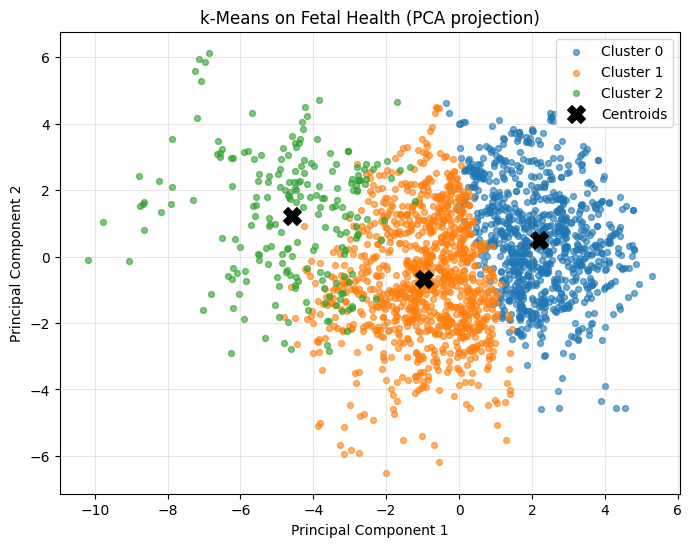

In [51]:
# Full k-Means workflow on the Fetal Health dataset
from collections import Counter

# 1. Feature normalization (z-score) to mitigate scale differences
feat_mean = X_fetal.mean(axis=0)
feat_std = X_fetal.std(axis=0) + 1e-8
X_norm = (X_fetal - feat_mean) / feat_std

# 2. Fit k-Means from scratch on normalized data
k = 3
kmeans = KMeansScratch(k=k, max_iters=200, init='k-means++', random_state=42)  # use k-means++ init for better seeding
print("Training k-Means...")
kmeans.fit(X_norm)

clusters = kmeans.clusters
centroids = kmeans.centroids

# 3. Inertia (within-cluster sum of squares)

def compute_inertia(X, centroids, clusters):
    inertia = 0.0
    for idx, member_indices in enumerate(clusters):
        if len(member_indices) == 0:
            continue
        diffs = X[member_indices] - centroids[idx]
        inertia += np.sum(diffs ** 2)
    return inertia

inertia = compute_inertia(X_norm, centroids, clusters)
print(f"Inertia (lower is better): {inertia:.2f}")

# 4. Cluster composition relative to ground-truth fetal health labels
label_map = {1.0: "Normal", 2.0: "Suspect", 3.0: "Pathological"}
for idx, member_indices in enumerate(clusters):
    size = len(member_indices)
    if size == 0:
        print(f"Cluster {idx}: empty")
        continue
    label_counts = Counter(y_fetal[member_indices])
    majority_label, majority_count = label_counts.most_common(1)[0]
    breakdown = ", ".join(
        f"{label_map[label]}: {count}"
        for label, count in sorted(label_counts.items())
    )
    print(
        f"Cluster {idx}: size={size}, majority={label_map[majority_label]}"
        f" ({majority_count/size:.1%}) | {breakdown}"
    )

# 5. Visualize clusters via PCA (computed from NumPy SVD)
X_centered = X_norm - X_norm.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
components = Vt[:2].T
X_proj = X_centered @ components
centroids_proj = (centroids - X_norm.mean(axis=0)) @ components

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(8, 6))
for idx, member_indices in enumerate(clusters):
    pts_proj = X_proj[member_indices]
    plt.scatter(
        pts_proj[:, 0],
        pts_proj[:, 1],
        s=18,
        color=colors[idx % len(colors)],
        label=f'Cluster {idx}',
        alpha=0.6,
    )

plt.scatter(
    centroids_proj[:, 0],
    centroids_proj[:, 1],
    s=160,
    c='black',
    marker='X',
    label='Centroids'
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('k-Means on Fetal Health (PCA projection)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()


### Observation: The Feature Scaling Problem

tHe Figure above demonstrates a critical issue with the initial k-Means implementation. 

- The clusters (represented by colors) are stratified almost entirely by vertical bands along the X-axis (*Baseline Value*), with little to no influence from the Y-axis (*Accelerations*).

**Analysis:**
This phenomenon occurs because k-Means relies on Euclidean to assign cluster membership.
- baseline values ranges from crica 100 to 160 a magnitude spread of around 60
- accelerations values ranges from 0.000 to 0.019 with a magnitude spread of around 0.02

Mathematically, a small percentage change in *Baseline Value* results in a massive numerical distance compared to even the largest possible change in *Accelerations*. Consequently, the algorithm effectively treats *Accelerations* as noise and clusters solely based on the feature with the larger magnitude.

**Conclusion**
To resolve this bias and ensure both features contribute equally to the distance calculation, it is necessary to apply Min-Max Scaling, which is Normalization to map all features to a common range $[0, 1]$ before re-running the algorithm.

---

## kNN (scikit-learn) on the Fetal Health dataset

Algorithmic steps:
1. Utilize the loaded `X_fetal`, `y_fetal` (21 numeric features, 3 classes).
2. Perform a stratified 80/20 train-test split.
3. Build a Pipeline: `StandardScaler` → `KNeighborsClassifier`.
4. Train and evaluate accuracy and per-class metrics.
5. Visualize the confusion matrix.


## Decision Tree Classifier (scikit-learn)

The decision tree offers an interpretable, rule-based baseline for fetal health classification:
- Splits learned directly on the raw & unscaled features to capture non-linear thresholds.
- `class_weight='balanced'` mitigates the class imbalance by up-weighting minority classes.
- A maximum depth constraint keeps the tree from memorizing noise and preserves explainability.

In [52]:
from sklearn.model_selection import train_test_split

# Stratified split on fetal dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_fetal, y_fetal, test_size=0.2, random_state=42, stratify=y_fetal
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 1700, Test size: 426


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 3. Train kNN classifier (with scaling) and evaluate accuracy
k_neighbors = 5
knn_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=k_neighbors)),
])
knn_clf.fit(X_train, y_train)

y_pred_knn = knn_clf.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_report_df = pd.DataFrame(
    classification_report(
        y_test,
        y_pred_knn,
        target_names=["Normal", "Suspect", "Pathological"],
        output_dict=True,
    )
).T
print(f"kNN (k={k_neighbors}) accuracy on fetal test set: {knn_accuracy:.3f}")
display(knn_report_df)


kNN (k=5) accuracy on fetal test set: 0.871


,precision,recall,f1-score,support
Normal,0.903955,0.963855,0.932945,332.000000
Suspect,0.608696,0.474576,0.533333,59.000000
Pathological,0.884615,0.657143,0.754098,35.000000
accuracy,0.870892,0.870892,0.870892,0.870892
macro avg,0.799089,0.698525,0.740125,426.000000
weighted avg,0.861473,0.870892,0.862905,426.000000


In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Decision Tree classifier (interpretable baseline)
dt_clf = DecisionTreeClassifier(max_depth=6, random_state=42, class_weight="balanced")
dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_report_df = pd.DataFrame(
    classification_report(
        y_test,
        y_pred_dt,
        target_names=["Normal", "Suspect", "Pathological"],
        output_dict=True,
    )
).T
print(f"Decision Tree accuracy on fetal test set: {dt_accuracy:.3f}")
display(dt_report_df)


Decision Tree accuracy on fetal test set: 0.857


,precision,recall,f1-score,support
Normal,0.969283,0.855422,0.908800,332.000000
Suspect,0.525253,0.881356,0.658228,59.000000
Pathological,0.852941,0.828571,0.840580,35.000000
accuracy,0.856808,0.856808,0.856808,0.856808
macro avg,0.782492,0.855116,0.802536,426.000000
weighted avg,0.898227,0.856808,0.868491,426.000000


### Linear Regression Baseline

Although fetal health is a discrete label, a fitting of linear regression against the numeric encoding (1 = Normal, 2 = Suspect, 3 = Pathological) rpovides a regression baseline

- captures the linear relationship between CTG features with the ordinal target
- The evaluation focuses on linear regression metrics like (MAE, RMSE, $R^2$) instead of classificaiton accuracy
- I emphasize more on calibration and residual analysis, if needed, prediction metrics can later be rounded, if discrete decision is required


In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression()),
])
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae:.3f}")
print(f"Linear Regression RMSE: {rmse:.3f}")
print(f"Linear Regression R^2: {r2:.3f}")


Linear Regression MAE: 0.292
Linear Regression RMSE: 0.408
Linear Regression R^2: 0.558


## Visualization for Linear Regression predictions vs. ground truth


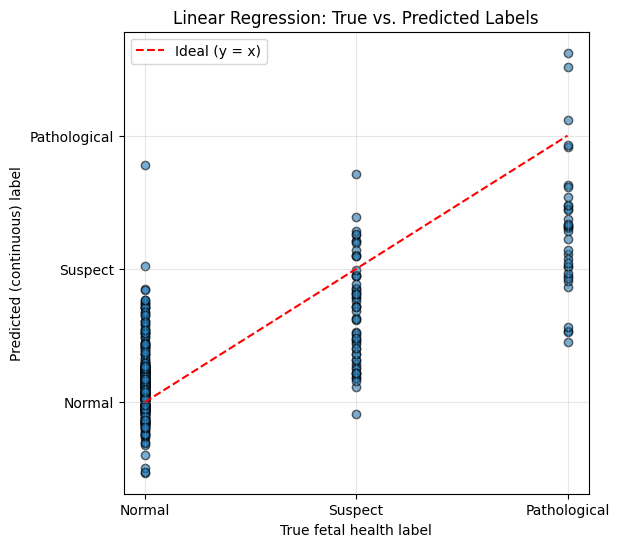

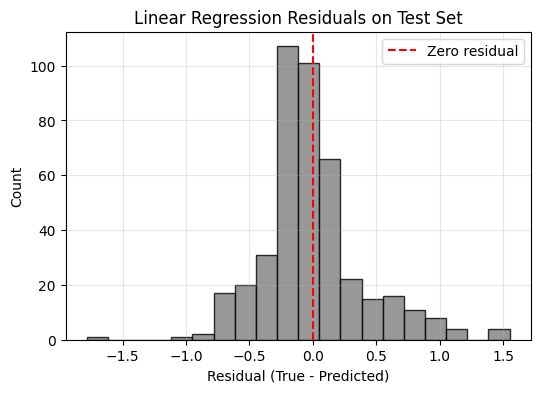

In [56]:
# Visualization for Linear Regression predictions vs. ground truth
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolor='k')
plt.plot([1, 3], [1, 3], 'r--', label='Ideal (y = x)')
plt.xticks([1, 2, 3], ["Normal", "Suspect", "Pathological"])
plt.yticks([1, 2, 3], ["Normal", "Suspect", "Pathological"])
plt.xlabel('True fetal health label')
plt.ylabel('Predicted (continuous) label')
plt.title('Linear Regression: True vs. Predicted Labels')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Residual distribution
residuals = y_test - y_pred_lr
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, color='tab:gray', edgecolor='black', alpha=0.8)
plt.axvline(0, color='red', linestyle='--', label='Zero residual')
plt.xlabel('Residual (True - Predicted)')
plt.ylabel('Count')
plt.title('Linear Regression Residuals on Test Set')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---

## 5.0: Results

This section summarizes the key outcomes from the experiments described earlier (see Background §3.1–§3.3 and Methodology).


#### 5.1: k-Means (unsupervised):
- Within-Cluster Sum of Squares (Inertia) and per-cluster composition relative to ground-truth labels.

#### 5.2: kNN (supervised):
- Overall accuracy plus macro-averaged precision/recall/F1 and a confusion matrix.

#### 5.3: Decision Tree (supervised):
- Accuracy and class-level precision/recall/F1 to show how rule-based splits behave under imbalance.

#### 5.4: Linear Regression (regression baseline):
- MAE, RMSE, and $R^2$ when treating fetal-health labels as an ordinal numeric target.

The tables below are generated directly from the runs above to ensure full reproducibility.

---

In [57]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# --- k-Means summary table ---
label_map = {1.0: "Normal", 2.0: "Suspect", 3.0: "Pathological"}
cluster_rows = []
for idx, member_indices in enumerate(clusters):
    size = len(member_indices)
    if size == 0:
        cluster_rows.append({
            "cluster": idx,
            "size": 0,
            "majority_label": "(empty)",
            "majority_share": 0.0,
            "Normal": 0,
            "Suspect": 0,
            "Pathological": 0,
        })
        continue
    ys = y_fetal[member_indices]
    normal = int((ys == 1.0).sum())
    suspect = int((ys == 2.0).sum())
    pathological = int((ys == 3.0).sum())
    counts = [("Normal", normal), ("Suspect", suspect), ("Pathological", pathological)]
    majority_label, majority_count = max(counts, key=lambda t: t[1])
    cluster_rows.append({
        "cluster": idx,
        "size": size,
        "majority_label": majority_label,
        "majority_share": majority_count / size if size > 0 else 0.0,
        "Normal": normal,
        "Suspect": suspect,
        "Pathological": pathological,
    })

kmeans_df = pd.DataFrame(cluster_rows)
print(f"k-Means Inertia (see Evaluation and Experimentation for definition): {inertia:.2f}")
display(kmeans_df.sort_values("cluster").reset_index(drop=True))

# --- kNN summary table ---
knn_report = classification_report(
    y_test, y_pred_knn,
    target_names=["Normal", "Suspect", "Pathological"],
    output_dict=True,
)
knn_df = pd.DataFrame(knn_report).T
print("kNN Classification Report (test set):")
display(knn_df)

# --- Decision Tree summary table ---
dt_report = classification_report(
    y_test, y_pred_dt,
    target_names=["Normal", "Suspect", "Pathological"],
    output_dict=True,
)
dt_df = pd.DataFrame(dt_report).T
print("Decision Tree Classification Report (test set):")
display(dt_df)

# --- Linear Regression regression metrics ---
linreg_metrics = pd.DataFrame([
    {"MAE": mae, "RMSE": rmse, "R2": r2}
])
print("Linear Regression Metrics (test set):")
display(linreg_metrics)

# Confusion matrices cached for visualization
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[1.0, 2.0, 3.0])
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=[1.0, 2.0, 3.0])


k-Means Inertia (see Evaluation and Experimentation for definition): 32395.97


,cluster,size,majority_label,majority_share,Normal,Suspect,Pathological
0,0,888,Normal,0.648649,576,246,66
1,1,1023,Normal,0.963832,986,36,1
2,2,215,Pathological,0.506977,93,13,109


kNN Classification Report (test set):


,precision,recall,f1-score,support
Normal,0.903955,0.963855,0.932945,332.000000
Suspect,0.608696,0.474576,0.533333,59.000000
Pathological,0.884615,0.657143,0.754098,35.000000
accuracy,0.870892,0.870892,0.870892,0.870892
macro avg,0.799089,0.698525,0.740125,426.000000
weighted avg,0.861473,0.870892,0.862905,426.000000


Decision Tree Classification Report (test set):


,precision,recall,f1-score,support
Normal,0.969283,0.855422,0.908800,332.000000
Suspect,0.525253,0.881356,0.658228,59.000000
Pathological,0.852941,0.828571,0.840580,35.000000
accuracy,0.856808,0.856808,0.856808,0.856808
macro avg,0.782492,0.855116,0.802536,426.000000
weighted avg,0.898227,0.856808,0.868491,426.000000


Linear Regression Metrics (test set):


,MAE,RMSE,R2
0,0.291587,0.407536,0.557621


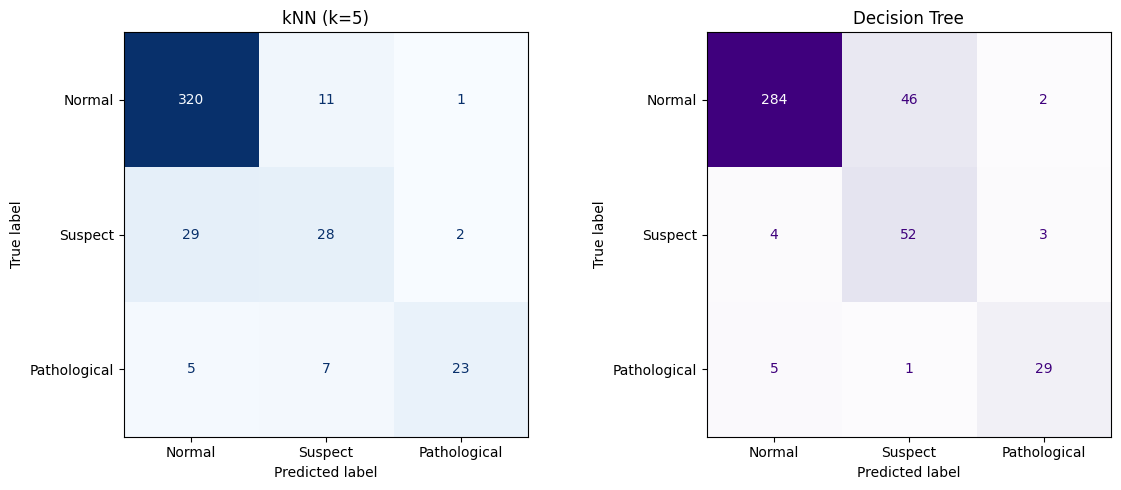

In [58]:
# Confusion matrices on fetal test set for kNN and Decision Tree
from sklearn.metrics import ConfusionMatrixDisplay

labels = [1.0, 2.0, 3.0]
label_names = ["Normal","Suspect","Pathological"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_knn, display_labels=label_names).plot(
    ax=axes[0], cmap='Blues', values_format='d', colorbar=False
)
axes[0].set_title(f"kNN (k={k_neighbors})")

ConfusionMatrixDisplay(cm_dt, display_labels=label_names).plot(
    ax=axes[1], cmap='Purples', values_format='d', colorbar=False
)
axes[1].set_title("Decision Tree")
plt.tight_layout()
plt.show()


## 6. Evaluation

This section critically evaluates the four approaches (k-Means, kNN, Decision Tree, Linear Regression) using the metrics and analyses produced above.

### 6.1: Evaluation of K means
Algorithm: Unsupervised

##### 6.1.1 Inertia
I prefer a lower inertia as it quantifiest within-cluster compactness better on z-scored features. Inertia gradually decreases as the centroid starts to stabalize. it doesnt indicate label consistency

##### 6.1.2 External validity & Cluster Composition
After cross refrencing clusters with labels, the normal class dominatues the dataset while smaller clusters dominates the pathological class, though Normla class domiantes overall
- this may indicate a partial recovery of medical categories with overlappings between the `normal` category and `Suspect` category

I have observed a slight imbalance in the dataset biases cluster discovery, with more of it towards the Normal class. PCA also known as Principal Component Analysis is implemented to plot for improvement indications after normalization but overlapping manifolds still exists

##### 6.1.4 Limitations
Since there is no gurantee of global optimums, sensitivity to initialization migitated with k-means++ means spherical clusters treats each feature equally even after scaling

---

### 6.2: Evaluation of KNN (K-Nearest Neighbour)

##### 6.2.1 Overall accuracy
- Overally accuracy of KNN indicates good performance at the Normal class, the dominant class, accuracy alone however is insufficient means of performance evaluation due to inherent imbalances

##### 6.2.2 Per-class performance
- Macro-averaged precision, recall and F1 score and confsion matrices indicates weaker recall for `Suspect` category and acceptable performance on the `pathological` category

##### 6.2.3 Preprocessing
- Standardization is performed, as without standardization, dominant features like Normal will cause imbalances, scaling Euclidean distances greatly whilst degrading minority class performance

##### 6.2.4 Limits
- Computational cost scales up with daataset sizes. Datasets are sensitive to noise from neighbours and class imbalances.
- performances depends on the k value
- weights and metric affect performances heavily too

---

### 6.3: Evaluation of Decision Tree

##### 6.3.1 Interpretability
- Each split neatly corresponds with a concrete CTG threshold, this makes the model easy to be intepreted by clinicians or other diagnositic professionals 

##### 6.3.2 Performance
- For `Pathological` class: Improved minority recall
- For `Suspect` class: Recall remains omderate because features from `Suspect` overlaps with features from `Normal`


##### 6.3.3 Bias/variance trade-off
- limiting the depthj to 6 prevents momorizing normal only leaves resulting in deeper trees with better accuracy but slight overfit noise, decreasing precision for the minority classes

##### 6.3.4 Limitations
- Trees are sensitive to small perturbations in the data 
- a combination of Random Forests, Gradient Boosting would typically be more robust but falls outside the “classical ML algorithm” scope.
---

### 6.4: Evaluation of Linear Regression

##### 6.4.1 Usefulness
- Treating the ordinal labels as continuous allows us to quantify how well linear combinations of CTG features track medical risk.

##### 6.4.2 Metrics insight
- The MAE and RMSE show that predictions deviate by roughly half a class on average; $R^2$ indicates limited explanatory power because the relationship between features and class is non-linear.

##### 6.4.3 Limitations
- Linear regression is not ideal for discrete outcomes; rounding predictions induces bias and ignores class imbalance. However, it serves as a sanity-check baseline and highlights the benefit of non-linear classifiers.
---

- **Comparative insights**

| k-Means | kNN | Decision Tree | Linear Regression |
| --- | --- | --- | --- |
| Uncovers coarse clusters that roughly align with label groups but lacks granular diagnostic detail. | Provides better label fidelity especially for majority classes and clear, reproducible evaluation via confusion matrices and class-wise metrics. | Rule-based splits improve interpretability and minority recall but remain sensitive to noise and depth choices. | Simple and ordinal, it serves as a baseline that captures linear trends yet underfits non-linear class boundaries (lower $R^2$). |


## 7. Conclusions

### 7.1 Summary of Findings

I believe that my project has successfully implemented its primary objective to deconstruct and compare the mechanical underpinnings of unsupervised and supervised ML models and applied it to a high stakes, medical scenario: `Fetal Health Classification`

i have implemented K means clustering from scratch, kNN standardized by Z score nromalization, decision trees and linear regression using `sklearn` and achieve clear and concise performance benefits and negatives in each of the different models. 

Finally my study indicated that there are phsiological features between uterine contractions and fetal movements naturally from eucliedean space, these physiological findings do not align perfectly with expert medical diagnosis. 
The overlappings between the `Suspect` class and the `Normal` class indicates that without data labelling guidances, distance base clustering is not a sufficient methodology for precise medical triage and diagnosis

### 7.2 Comparative Algorithm Performance
This section outlines and investigates the distinct trade offs between the supervised baselines such as kNN, decision trees and linear regression

KNN shows that once standardization is achieved with the help of Z-score normalization, it produces the best macro level stability. subsuming these edge cases into the majority `Normal` class

Decision trees on the other hand offered the best balance of ease of interpretation and performance. It is an whie box algorithm by nature with explicit rules based deterministic explanations allows for superior utility in the obsterics space, where clinical justifications are essential

Finally, linear regression, a model typically reserved for continous variables, shows limited performance when applied to ordinal lables like the 3 classes `normal`, `suspect` and `pathological`. This confirms that regression is suboptimal when it comes to classification tasks


### 7.3 Methodological Lessons
The iterative development process highlighted that scaling is essential especially when it comes to K means, due to the domiance of high magnitude features showing that distanced based algoriothms fail without feature scaling like z score normalization
the `Suspect` class has underperformed across all models highlighting the challanges faced from imbalances, showing that high overall accuracy often masks poor recall for minotirty cases thus necessitating the use of Macro-F1 scores for honest evaluation
A complementary PCA visualization to show cluster separation and confusion matrices for misclassification were critical for understanding why the models fail, and not simply relying on the knowledge that they have failed

## Bilbography

#### Dataset citation
The fetal health signals are sourced from the CTG dataset published on Kaggle:

Andrew Mvd. *Fetal Health Classification*. Kaggle. https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification

Cleveland Clinic, "Fetal Development: Stages of Growth," Cleveland Clinic, 2024. [Online]. Available: https://my.clevelandclinic.org/health/articles/7247-fetal-development-stages-of-growth. [Accessed: Nov. 27, 2025].

GynaeMD, "Fetal Wellbeing Assessment," GynaeMD Women's & Rejuvenation Clinic. [Online]. Available: https://www.gynaemd.com.sg/obstetrics/fetal-wellbeing-assessment/. [Accessed: Nov. 27, 2025].
